# 样例数据

In [46]:
import re     
import jieba 
import os
import nltk
import pandas as pd    
import numpy as np 
from nltk import pos_tag
from nltk.util import ngrams
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt     
from gensim.models import Word2Vec    
# import gensim.downloader as api     # 导入云端的已训练好的词向量
from gensim.models import KeyedVectors # 加载自己本地个性化的已训练好的词向量
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import cosine_similarity     # 计算向量之间的余弦相似度
from sklearn.decomposition import PCA     # 语义空间降维，用于展示词语在二维空间的相对位置

## 加载数据

In [3]:
df = pd.read_excel(r'C:\Users\Administrator\Desktop\词嵌入作业\text_analysis_ad.xlsx', index_col = 0)
df.head()

,index,商品名称,商品类别,出版年,广告文本,广告标题
0,1596,五华牌香烟[May Blossom],烟草制品,1932,兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟 二十枝装每包售国币大洋二角 五十枝装每罐售国币...,"五华牌香烟,""兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟"""
1,5627,韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People],药品,1918,讲求卫生为人生本性天理固然也 人生首贵逐日大便通畅有序为天然所当如此也如若大便不利大肠阻塞则...,韦廉士红色清导丸:'讲求卫生为人生本性天理固然也'
2,13532,大炮台香烟[Three Castles Cigarettes],烟草制品,1935,"香味馥郁,不让名花 另有三炮台出售","大炮台香烟,""香味馥郁 不让名花"""
3,1133,婴孩自己药片[Baby's Own],药品,1930,差肩儿女 秀慧康强 闽有佳音讃羡婴孩自己药片 每年此际小儿患肠胃病者甚多而尤以南方各地天气翳...,"婴孩自己药片,""差肩儿女 秀慧康强 闽有佳音赞美婴孩自己药片"""
4,3146,亚士北罗药片[Aspro],药品,1933,何以亚士北罗是妇女们的腻友？各国妇女力证亚士北罗药片是她们最需要的药物！为什么？她们的经验知...,"亚士北罗药片,""妇女之腻友"""


## 预处理

In [7]:
# 数据预处理
def data_preprocess(text):
    # 剔除符号与数字
    nonums_text = re.sub('[^\u4e00-\u9fa5]+', '', str(text))
        
    # 分词
    words = jieba.cut(nonums_text)
    
    # 去除停用词
    words = [w for w in words if w not in list(stopwords) and w!='\u200b']
    
    return ' '.join(words)

# 下载
stopwords = open(r'C:\Users\Administrator\Desktop\词嵌入作业\stopwords.txt', encoding = 'utf-8').read()
df['clean_text'] = df['广告文本'].apply(data_preprocess)

In [8]:
df

,index,商品名称,商品类别,出版年,广告文本,广告标题,clean_text
0,1596,五华牌香烟[May Blossom],烟草制品,1932,兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟 二十枝装每包售国币大洋二角 五十枝装每罐售国币...,"五华牌香烟,""兰勃脱白脱勒公司 五华牌香烟 佛及尼埃香烟""",兰勃 脱白 脱勒 公司 五华 牌 香烟 佛及 尼埃 香烟 二十 枝装 每包 售 国币 大洋 ...
1,5627,韦廉士红色清导丸[Dr.Willams' Pink Pills For Pale People],药品,1918,讲求卫生为人生本性天理固然也 人生首贵逐日大便通畅有序为天然所当如此也如若大便不利大肠阻塞则...,韦廉士红色清导丸:'讲求卫生为人生本性天理固然也',讲求 卫生 人生 本性 天理 固然 人生 首贵 逐日 大便 通畅 有序 天然 所当 如此 如...
2,13532,大炮台香烟[Three Castles Cigarettes],烟草制品,1935,"香味馥郁,不让名花 另有三炮台出售","大炮台香烟,""香味馥郁 不让名花""",香味 馥郁 不让 名花 炮台 出售
3,1133,婴孩自己药片[Baby's Own],药品,1930,差肩儿女 秀慧康强 闽有佳音讃羡婴孩自己药片 每年此际小儿患肠胃病者甚多而尤以南方各地天气翳...,"婴孩自己药片,""差肩儿女 秀慧康强 闽有佳音赞美婴孩自己药片""",差肩 儿女 秀慧 康强 闽有 佳音 讃 羡 婴孩 自己 药片 每年 此际 小儿 患 肠胃病 ...
4,3146,亚士北罗药片[Aspro],药品,1933,何以亚士北罗是妇女们的腻友？各国妇女力证亚士北罗药片是她们最需要的药物！为什么？她们的经验知...,"亚士北罗药片,""妇女之腻友""",何以 亚士 北罗 妇女 腻友 各国 妇女 力证 亚士 北罗 药片 她们 需要 药物 为什么 ...
...,...,...,...,...,...,...,...
495,14176,安住蚊烟香,化肥及杀虫剂,1935,安住蚊烟香 臭虫立毙药粉 世界第一名产 安住蚊烟香 蚊见逃慌慌 暑夜不用帐 包睡到天光 汉口...,"安住蚊烟香,""世界第一名产""",安住 蚊烟香 臭虫 立毙 药粉 世界 第一名 产安住 蚊烟香 蚊见 逃 慌慌 暑夜 不用 帐...
496,11610,第威德润肠丸[DeWitt's],药品,1934,眉色清秀 气色壮旺 此第威德润肠丸之功也 第威德润肠丸系以草药炼制纯粹和平十分安全功能清理肠...,"第威德润肠丸,""眉色清秀 气色壮旺""",眉色 清秀 气色 壮旺此 威德 润肠 丸 之功 威德 润肠 丸系 草药 炼制 纯粹 和平 十...
497,10256,如意膏[She-Ko],药品,1934,汤火烫伤 立攃如意膏可免严重之后果 皮肤受伤当以灼烫最痛苦其又因此震激而致命者治疗灼烫止痛消...,"如意膏,""汤火烫伤 立攃如意膏可免严重之后果""",汤火 烫伤 攃 如意 膏 可免 严重 后果 皮肤 受伤 当以 灼烫 痛苦 因此 震激 致命 ...
498,9176,六零六药膏,药品,1923,清血解毒六零六 花柳梅毒瘰*疮疖癣疥**及筋骨酸痛四肢麻木半身疯*等症状虽异其发生之原理莫不...,"六零六,""清血解毒六零六""",清血 解毒 六零 花柳 梅毒 瘰疮 疖 癣疥 筋骨 酸痛 四肢 麻木 半身 疯 症状 虽异 ...


## 训练词嵌入模型

In [15]:
# 准备训练语料库
corpus = df['clean_text'].apply(lambda x: x.split(' ')).tolist()
for item in corpus[:3]:
    print(item)

['兰勃', '脱白', '脱勒', '公司', '五华', '牌', '香烟', '佛及', '尼埃', '香烟', '二十', '枝装', '每包', '售', '国币', '大洋', '二角', '五十', '枝装', '每罐', '售', '国币', '大洋', '五角']
['讲求', '卫生', '人生', '本性', '天理', '固然', '人生', '首贵', '逐日', '大便', '通畅', '有序', '天然', '所当', '如此', '如若', '大便', '不利', '肠阻塞', '胃失', '消化', '疾病', '头痛', '肝火', '上升', '胆汁', '口气', '积浊', '舌现', '黄苔', '诸恙', '接踵', '凡', '此皆须', '服用', '韦廉士', '医生', '红色', '清导丸', '以利', '大便', '俾得', '体质', '强健', '百病', '不侵', '也况', '此丸', '功力', '天然', '平和', '不尚', '霸烈', '广东省', '城', '医生', '学', '研究会', '先生', '来示', '云弟', '患大', '便秘', '结之症', '一月', '有余', '困苦', '万状', '难以', '言喻', '服用', '韦廉士', '红色', '清导丸', '数粒', '大便', '畅达', '于是', '常为', '服用', '身体', '爽健为', '半生', '以来', '未有', '尊处', '无从', '购买', '韦廉士', '红色', '清导丸', '祈即', '邮票', '大洋', '六角', '上海', '四川', '路', '九十六', '号', '韦廉士', '医生', '药局', '原班', '邮奉', '一瓶']
['香味', '馥郁', '不让', '名花', '炮台', '出售']


In [16]:
# 训练
model = Word2Vec(
    corpus,    
    window = 5,     
    vector_size = 100,    
    min_count = 1,     
    epochs = 10
)

# 保存训练好的模型
model.save('word2vec_ad.model')

In [20]:
# 简单查看词汇表和词向量
word_list = model.wv.index_to_key 
len(word_list)

9610

In [23]:
word_vectors = model.wv[word_list]
# word_vectors

In [24]:
# 计算模型中两个词之间的余弦相似性
print(model.wv.similarity('医生', '卫生'))
print(model.wv.similarity('疼痛', '神经'))

0.6743863
0.99331915


In [25]:
# 计算一个词在模型中与这个词最相近的词。
most_similar_words = model.wv.most_similar('医生', topn=5)
print(most_similar_words)

[('韦廉士', 0.9955029487609863), ('药局', 0.9807550311088562), ('一号', 0.972586452960968), ('红色', 0.965548038482666), ('定价', 0.9648661017417908)]


## 可视化

In [28]:
words = ['医生', '疼痛', '神经', '伤风']
model.wv["医生"]

array([-0.9147408 ,  1.2112402 ,  0.54491246,  0.81133807, -1.230619  ,
       -0.9506701 ,  0.2393207 ,  1.501963  , -1.1551563 , -0.586017  ,
       -0.10914683, -1.0554574 , -0.16861883,  0.72466415,  0.10479065,
       -0.26219982,  1.6910211 , -0.60178983, -0.36420578, -2.4262266 ,
        0.11908425,  0.56545067,  1.1504486 , -0.46105674,  0.12358102,
        0.6785319 , -1.6451132 , -0.3809652 , -0.6340201 ,  0.8504238 ,
        1.3953846 , -0.41685513,  1.5196522 , -0.90092105, -0.69217706,
        0.7004891 , -0.18934081, -0.41727623, -0.2546648 , -0.9631949 ,
        0.40406382, -0.59658355, -0.9674991 ,  0.92322326,  0.40477434,
       -0.9727549 , -0.55913407, -0.55404586,  0.24901134,  0.6387386 ,
        0.5562094 , -0.50535053, -0.98554236,  0.23112024, -0.47010922,
        0.0455104 ,  0.4672912 , -0.36169285, -0.4800164 ,  0.20367189,
        0.19835114,  0.43482202,  0.14299656,  0.01861222, -0.7773677 ,
        1.1145357 , -0.10565479, -0.07744911, -1.2582309 ,  0.89

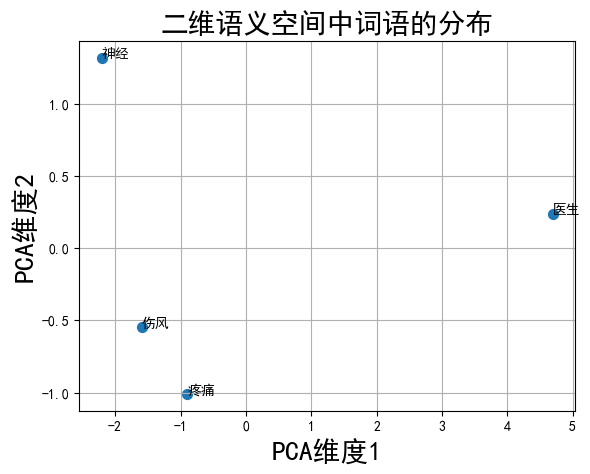

In [32]:
# 可视化
vectors = [model.wv[word] for word in words]

# 使用PCA进行降维
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(vectors)

# 画图前准备，字体、负号处理以及画图窗口
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure()

# 取PCA降维结果中所有行的第一列和第二列数据绘制散点图，设置点的大小为50
plt.scatter(pca_result[:, 0], pca_result[:, 1], s = 50)

# 注释
for i, word in enumerate(words):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]), fontsize = 10)

plt.xlabel('PCA维度1', fontsize = 20)
plt.ylabel('PCA维度2', fontsize = 20)
plt.title('二维语义空间中词语的分布', fontsize = 20)
plt.grid(True)
plt.show()

# 个人语料库（美国故事数据集切片）

## 准备数据

In [60]:
all_folder = r"D:\American Stories\American story csv 1920-1940"
data_frame = []
for second_folder in tqdm(os.listdir(all_folder)):
    path = os.path.join(all_folder,second_folder)
    for file_name in os.listdir(path):
        file_path = os.path.join(path,file_name)
        df = pd.read_csv(file_path)
        random_sample = df.sample(n=100)
        data_frame.append(random_sample)
data = pd.concat(data_frame,axis=0) 

  0%|          | 0/21 [00:00<?, ?it/s]

In [42]:
data_write = data.to_csv("American_story_sample_100.csv",index = False)

## 加载数据

In [45]:
df = pd.read_csv(r'D:\American Stories\American_story_sample_100.csv')
df.head()

,Article_id,Date,Page_number,Newspaper_name,Headline,Author,Article_body
0,4_1920-01-09_p1_sn99062049_00415624992_1920010...,1920-01-09,p1,NaN,Presbyterian ChurchDemobilizes Service Flag,NaN,The services at the PresbyterianChurch Sunday ...
1,23_1920-01-05_p1_sn91066782_00415627932_192001...,1920-01-05,p1,NaN,Lumber Exports VS.. Production.,NaN,"Only Al per, cent of the total lum.ber product..."
2,16_1920-01-09_p1_sn86063730_00332894857_192001...,1920-01-09,p1,NaN,WILSON AND BRYANfUIESSAGESSURPRISES OF JACKSON...,NaN,"with Germany. was thus disclosed asa fact, alt..."
3,14_1920-01-24_p7_sn83025514_00340586384_192001...,1920-01-24,p7,The Colorado statesman.,NaN,NaN,Apple Snow.-Pare and quarter tartapples. add b...
4,40_1920-01-03_p4_sn83025458_00414217370_192001...,1920-01-03,p4,The daily morning oasis.,NaN,NaN,"Mr.. A. Ybarra, counsel for theSouthern Pacifi..."


## 数据预处理

In [47]:
# 下载
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [48]:
## Data Cleaning and Text Processing.
def preprocess_text(text):
    # 小写
    text = text.lower()
    
    # 分词
    tokens = word_tokenize(text)
    
    # 去除停用词
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words]
    
    # 去除标点符号和数字 和其他一些字符
    filtered_tokens = [word for word in filtered_tokens if word.isalpha() ]
    #filtered_tokens = [word for word in filtered_tokens if word not in string.punctuation]
    
    # 词性标注与筛选
    #pos_tags = pos_tag(filtered_tokens)
    #selected_tokens = [word  for word, pos in pos_tags if pos.startswith('N') or pos.startswith('J') or pos.startswith('V')]
    
    # 词性还原
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in filtered_tokens]
  
    # 返回预处理后的文本
    return ' '.join(lemmatized_tokens)


# 定义函数将词性标签映射到 WordNet 词性标签
# def get_wordnet_pos(treebank_tag):
#     if treebank_tag.startswith('J'):
#         return 'a'  # 形容词
#     elif treebank_tag.startswith('V'):
#         return 'v'  # 动词
#     elif treebank_tag.startswith('N'):
#         return 'n'  # 名词
#     else:
#         return None  # 默认为名词

df['text_clean'] = df['Article_body'].apply(preprocess_text)    

In [49]:
df.head()

,Article_id,Date,Page_number,Newspaper_name,Headline,Author,Article_body,text_clean
0,4_1920-01-09_p1_sn99062049_00415624992_1920010...,1920-01-09,p1,NaN,Presbyterian ChurchDemobilizes Service Flag,NaN,The services at the PresbyterianChurch Sunday ...,service presbyterianchurch sunday evening full...
1,23_1920-01-05_p1_sn91066782_00415627932_192001...,1920-01-05,p1,NaN,Lumber Exports VS.. Production.,NaN,"Only Al per, cent of the total lum.ber product...",al per cent total production united stateswas ...
2,16_1920-01-09_p1_sn86063730_00332894857_192001...,1920-01-09,p1,NaN,WILSON AND BRYANfUIESSAGESSURPRISES OF JACKSON...,NaN,"with Germany. was thus disclosed asa fact, alt...",germany thus disclosed asa fact although rumor...
3,14_1920-01-24_p7_sn83025514_00340586384_192001...,1920-01-24,p7,The Colorado statesman.,NaN,NaN,Apple Snow.-Pare and quarter tartapples. add b...,apple quarter tartapples add boiling water coo...
4,40_1920-01-03_p4_sn83025458_00414217370_192001...,1920-01-03,p4,The daily morning oasis.,NaN,NaN,"Mr.. A. Ybarra, counsel for theSouthern Pacifi...",mr ybarra counsel thesouthern pacific mexico h...


## 训练词嵌入模型

In [51]:
# 准备训练语料库
corpus = df['text_clean'].apply(lambda x: x.split(' ')).tolist()
for item in corpus[:2]:
    print(item)

['service', 'presbyterianchurch', 'sunday', 'evening', 'fulluf', 'patriotic', 'sentimentand', 'thoroughly', 'saturated', 'cremate', 'hidiousmonster', 'violence', 'hatredmas', 'usurped', 'part', 'nationalfreedom', 'institution', 'lieso', 'close', 'heart', 'mr', 'first', 'addressed', 'word', 'could', 'per', 'centamerican', 'listenrs', 'whomay', 'patriotically', 'lukewarm', 'appealed', 'way', 'mayhave', 'caused', 'think', 'afterall', 'precious', 'epithet', 'thatcould', 'applied', 'man', 'iais', 'real', 'american', 'allfriction', 'eradicated', 'ournational', 'life', 'authority', 'hasbeen', 'gained', 'faction', 'climbing', 'inthe', 'platform', 'misinterpreted', 'misguided', 'conclusionswill', 'restored', 'without', 'reluctanceto', 'unstained', 'hand', 'sofar', 'kept', 'u', 'light', 'freedom', 'ongstreth', 'also', 'called', 'unonto', 'speak', 'doctor', 'spoke', 'thestandpoint', 'soldier', 'revealedmany', 'instance', 'hardshinthat', 'undergone', 'soldiersin', 'france', 'talk', 'also', 'filmdw

In [56]:
# 训练
model = Word2Vec(
    corpus,    
    window = 5,     
    vector_size = 300,    
    min_count = 1,     
    epochs = 10
)

# 保存训练好的模型
model.save('American_story_word2vec_ad.model')

In [57]:
# 计算一个词在模型中与这个词最相近的词。
most_similar_panic = model.wv.most_similar('panic', topn=5)
most_similar_confidence = model.wv.most_similar('confidence', topn=5)
print(most_similar_panic)
print(most_similar_confidence)

[('oflife', 0.9560295939445496), ('severely', 0.9536592960357666), ('lookout', 0.9529877305030823), ('lung', 0.9510741829872131), ('rundown', 0.9504612684249878)]
[('politician', 0.9625042080879211), ('regarded', 0.9594207406044006), ('propaganda', 0.9587284922599792), ('arise', 0.95802241563797), ('democracy', 0.9569937586784363)]


## 可视化

In [58]:
words = ['homicide', 'suicide', 'morality', 'economy']

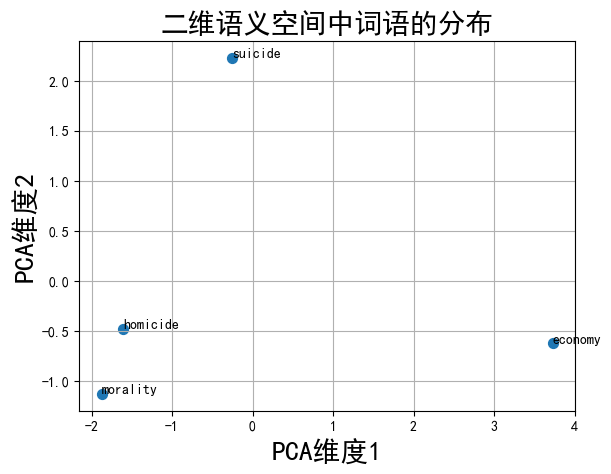

In [59]:
# 可视化
vectors = [model.wv[word] for word in words]

# 使用PCA进行降维
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(vectors)

# 画图前准备，字体、负号处理以及画图窗口
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure()

# 取PCA降维结果中所有行的第一列和第二列数据绘制散点图，设置点的大小为50
plt.scatter(pca_result[:, 0], pca_result[:, 1], s = 50)

# 注释
for i, word in enumerate(words):
    plt.annotate(word, (pca_result[i, 0], pca_result[i, 1]), fontsize = 10)

plt.xlabel('PCA维度1', fontsize = 20)
plt.ylabel('PCA维度2', fontsize = 20)
plt.title('二维语义空间中词语的分布', fontsize = 20)
plt.grid(True)
plt.show()